# Install and Import Libraries

In [91]:
!pip install torch torchvision
!pip install numpy pandas matplotlib tqdm pillow --quiet

### Libraries for OS and Cloud

In [50]:
import os
import uuid
import shutil
import json
import copy
from datetime import datetime
import zipfile
import io
import requests
import random

### Libraries for Data Processing and Visualization

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time

### Deep Learning Libraries

In [92]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
from torchvision.datasets import ImageFolder
from torchvision import transforms

## Plot train cost and validation accuracy:

In [53]:
def plot_stuff(COST, ACC):

    # Create a new figure and primary axis (ax1)
    fig, ax1 = plt.subplots()

    # Plot training loss on the primary y-axis (left)
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('Iteration', color=color)
    ax1.set_ylabel('Total Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a secondary y-axis (ax2) sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot validation accuracy on the secondary y-axis (right)
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adjust layout to prevent y-label clipping
    fig.tight_layout()

    # Display the combined plot
    plt.show()

## Plot the transformed image:

In [54]:
def imshow_(inp, title = None):

    # Convert to numpy array
    inp=inp.permute(1,2,0).numpy()
    print("Image shape:", inp.shape)

    # Undo normalization (ImageNet mean and std)
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean

    # Clip values to [0,1] for display
    inp=np.clip(inp,0,1)

    # Display image
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


# Image Processing and Load Data for Dataset preparation¶


## Load Data for Dataset preparation

#### Splits image data into training and validation sets: 90% of the data will be used for training.

### Set Path

In [56]:
# sets path
source_dir = "D:/Downloads/final-project-stop-signs"
annotations_file = os.path.join(source_dir, "_annotations.json")

### Load Annotations

In [57]:
# Load annotations
with open(annotations_file, "r") as f:
    annotations = json.load(f)

### Set Parameters

In [58]:
# Parameters
train_ratio = 0.9
output_dir = "dataset"

### Prepare Label to Image Mapping

In [59]:
# Prepare label --> image list
label_to_images = {}

for filename, entry in annotations["annotations"].items():
    label = entry[0]["label"]
    label_to_images.setdefault(label, []).append(filename)

### Shuffle and Split into Train/Validation

In [60]:
# Shuffle and split each class into training and validation sets
for lable, image_list in label_to_images.items():
    random.shuffle(image_list)

    # Calculate the numbber of training images (e.g., 90% of total)
    train_cutoff = int(len(image_list) * train_ratio)

    # Split the image list into training and validation sets
    train_images = image_list[:train_cutoff]
    val_images = image_list[train_cutoff:]

    # Loop over both splits: 'train' and 'val'
    for split, split_images in zip(["train", "val"], [train_images, val_images]):

        # Create the output directory for the current split and label
        out_path = os.path.join(output_dir, split, label)
        os.makedirs(out_path, exist_ok=True)

        # Copy each image from the source directory to the appropriate split folder
        for img_name in  split_images:
            src = os.path.join(source_dir, img_name)
            dst = os.path.join(out_path, img_name)
            shutil.copy2(src, dst)

# Print completion message once all images are copied
print("Train/Val split complete.")

Train/Val split complete.


#### Splitting Dataset: 90% Training, 10% Validation
#### We define train_ratio = 0.9 and apply it to split each class. The first 90% of shuffled images are used for training, and the remaining 10% for validation.

## Image Transformations

In [61]:
# Define a series of transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224×224 pixels to ensure consistent input dimensions.
    transforms.ToTensor(),              # Convert image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # Mean for ImageNet pretrained models
        std=[0.229, 0.224, 0.225]       # Std deviation for ImageNet pretrained models
    )
])

#### These normalization values center the data similarly to how the pretrained models were originally trained, which helps improve performance and convergence.

## Load Datasets with Transformations

In [62]:
from torchvision.datasets import ImageFolder

# Load datasets from the respective folders
train_dataset = ImageFolder(root="dataset/train", transform=transform)
val_dataset = ImageFolder(root="dataset/val", transform=transform)

#### No augmentation is applied to the validation set, we want to evaluate model performance on real, unmodified images.

## Visualize Samples from the Validation Set

Image shape: (224, 224, 3)


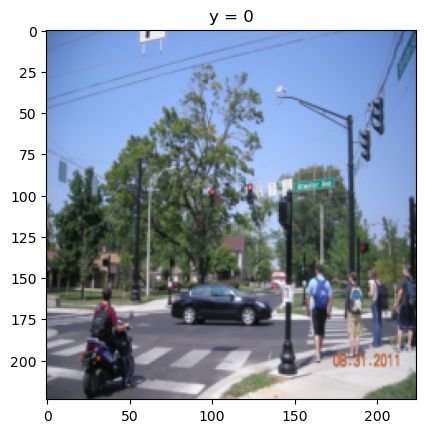

Image shape: (224, 224, 3)


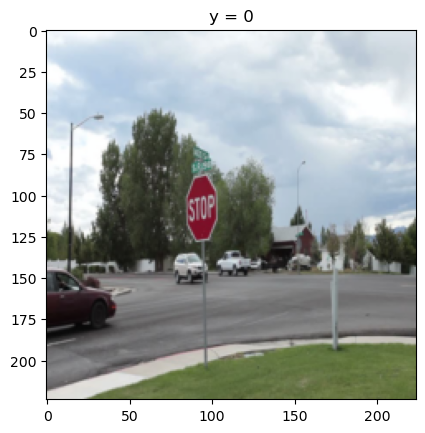

Image shape: (224, 224, 3)


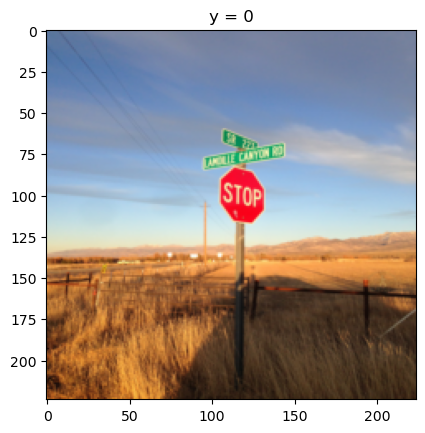

In [63]:
# Loop through the validation dataset and display the first 3 images
# Loop through the dataset (x: image tensor, y: label)
# Display the image with its label using a custom display function
# Stop after showing 3 images
# Increment the counter
i = 0
for x, y in val_dataset:
    imshow_(x, f"y = {y}")
    i += 1               
    if i == 3:        
        break

#### Early visual inspection helps catch issues in image format, normalization, or label mismatch before training the model.

## Reflect on Your Dataset and Transformations

After applying transformations and visualizing sample images,

1. Why is normalization important when using pretrained models?

- Normalization ensures that input images have the same mean and standard deviation as the data used to train the pretrained model (ImageNet). This keeps the input distribution consistent, allowing the pretrained weights to function correctly and improving model performance and convergence.

2. What benefits does resizing the images to (224, 224) provide?

- Resizing ensures all images have a consistent input size that matches the expected input dimensions of ResNet18 (224×224). This allows batch processing and ensures compatibility with the pretrained architecture.

3. What would happen if input sizes varied?

- If input sizes varied, the model would raise dimension mismatch errors because convolutional neural networks require consistent input dimensions within a batch. It would also prevent proper matrix operations in the fully connected layers.

# Hyperparameters

## Epochs and Batch Size

In [64]:
# Set the number of epochs and batch size
n_epochs = 10
batch_size = 32

## Configure Learning Rate and Momentum

In [65]:
# Set optimizer hyperparameters
learning_rate = 0.001
momentum = 0.9

## Learning Rate Scheduler

In [66]:
# Enable learning rate scheduling
lr_scheduler = True
base_lr = 0.001
max_lr = 0.01

## Analyze Training Configuration

Reflecting on the training setup,

1. What is the purpose of choosing a specific number of epochs?
- The number of epochs determines how many times the model sees the entire training dataset. Too few epochs may result in underfitting, where the model does not learn the data patterns sufficiently. Too many epochs may cause overfitting, where the model memorizes the training data and performs poorly on unseen data. Choosing an appropriate number of epochs helps balance learning and generalization.

2. Why is it important to choose an appropriate batch size?
- Batch size affects training stability, convergence speed, and memory usage. Smaller batch sizes provide more frequent weight updates and may improve generalization but can be noisier. Larger batch sizes provide more stable gradient estimates and faster computation but require more memory. A balanced batch size (such as 32) offers stable training while remaining computationally efficient.

3. How does a learning rate scheduler help model training?
- A learning rate scheduler adjusts the learning rate during training. Starting with a higher learning rate allows the model to learn quickly, while gradually reducing it helps fine-tune the weights and improve convergence. This prevents overshooting optimal values and often improves overall model performance.

# Load Model and Train

## Load a Pretrained Model

In [67]:
# Set the parameter pretrained to true.
model = models.resnet18(pretrained=True)

## Freeze Feature Extractor Layers

In [68]:
# Freeze all the parameters to prevent updates during training
for param in model.parameters():
    param.requires_grad = False

## Determine the Number of Classes

In [69]:
# Find number of classes from the dataset
n_classes = len(train_dataset.classes)
print(n_classes)

1


## Replace the Output Layer

In [70]:
# Replace the output layer to match the number of classes
model.fc = nn.Linear(512, n_classes)

### Set device type

In [71]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define the Loss Function

In [72]:
# Replace the output layer to match the number of classes
model.fc = nn.Linear(512, n_classes)

## Create Data Loaders

In [73]:
# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1)

## Set Up the Optimizer

In [74]:
# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

## Configure a Learning Rate Scheduler

In [75]:
# Optional: use learning rate scheduler
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=base_lr,        # Minimum learning rate e.g 0.001
        max_lr=max_lr,          # Maximum learning rate e.g 0.01
        step_size_up=5,
        mode="triangular2"
    )

In [76]:
criterion = nn.CrossEntropyLoss()

## Implement and Analyze the Training Loop

In [77]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True):
    loss_list = []        # Store average training loss per epoch
    accuracy_list = []    # Store validation accuracy per epoch
    correct = 0

    n_test = len(val_dataset)
    accuracy_best = 0
    best_model_wts = copy.deepcopy(model.state_dict())  # Save initial best weights

    print("The first epoch should take several minutes")

    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            model.train()   # Set model to training mode

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())

            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights
            optimizer.zero_grad()  # Reset gradients

        print(f"Epoch {epoch + 1} done")

        # Step learning rate scheduler (if used)
        scheduler.step()

        loss_list.append(np.mean(loss_sublist))

        # Validation
        correct = 0
        model.eval()
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()

        accuracy = correct / n_test
        accuracy_list.append(accuracy)

        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        if print_:
            print("Learning rate:", optimizer.param_groups[0]['lr'])
            print(f"Validation loss (epoch {epoch + 1}): {np.mean(loss_sublist):.4f}")
            print(f"Validation accuracy (epoch {epoch + 1}): {accuracy:.4f}")

    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model

## Reflection

If we did not track the best model weights during training, we might end up using the weights from the final epoch, even if the model had already started overfitting. During training, validation performance may peak at an earlier epoch before decreasing. Without saving the best-performing weights, we could lose the version of the model that had the highest validation accuracy and best generalization performance.

#### Now we are going to train model,for the images this take 25 minutes, depending on your dataset

In [78]:
# Start time tracking
start_datetime = datetime.now()
start_time = time.time()

# Train the model
accuracy_list, loss_list, model = train_model(
    model, train_loader, validation_loader, criterion, optimizer, n_epochs=n_epochs)

# End time tracking
end_datetime = datetime.now()
elapsed_time = time.time() - start_time

# Print results
print("Training completed.")
print(f"Start Time     : {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End Time       : {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Elapsed Time   : {elapsed_time:.2f} seconds")

The first epoch should take several minutes


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1 done


 10%|████████▎                                                                          | 1/10 [00:23<03:32, 23.61s/it]

Learning rate: 0.002800000000000002
Validation loss (epoch 1): 0.0000
Validation accuracy (epoch 1): 1.0000
Epoch 2 done


 20%|████████████████▌                                                                  | 2/10 [00:41<02:39, 19.97s/it]

Learning rate: 0.0046
Validation loss (epoch 2): 0.0000
Validation accuracy (epoch 2): 1.0000
Epoch 3 done


 30%|████████████████████████▉                                                          | 3/10 [00:56<02:05, 17.90s/it]

Learning rate: 0.006400000000000001
Validation loss (epoch 3): 0.0000
Validation accuracy (epoch 3): 1.0000
Epoch 4 done


 40%|█████████████████████████████████▏                                                 | 4/10 [01:11<01:41, 16.86s/it]

Learning rate: 0.008199999999999999
Validation loss (epoch 4): 0.0000
Validation accuracy (epoch 4): 1.0000
Epoch 5 done


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:26<01:20, 16.20s/it]

Learning rate: 0.010000000000000002
Validation loss (epoch 5): 0.0000
Validation accuracy (epoch 5): 1.0000
Epoch 6 done


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:42<01:04, 16.06s/it]

Learning rate: 0.008199999999999999
Validation loss (epoch 6): 0.0000
Validation accuracy (epoch 6): 1.0000
Epoch 7 done


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:57<00:47, 15.74s/it]

Learning rate: 0.006400000000000001
Validation loss (epoch 7): 0.0000
Validation accuracy (epoch 7): 1.0000
Epoch 8 done


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:12<00:30, 15.41s/it]

Learning rate: 0.0046
Validation loss (epoch 8): 0.0000
Validation accuracy (epoch 8): 1.0000
Epoch 9 done


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:27<00:15, 15.40s/it]

Learning rate: 0.002800000000000002
Validation loss (epoch 9): 0.0000
Validation accuracy (epoch 9): 1.0000
Epoch 10 done


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.33s/it]

Learning rate: 0.001
Validation loss (epoch 10): 0.0000
Validation accuracy (epoch 10): 1.0000
Training completed.
Start Time     : 2026-02-02 14:00:05
End Time       : 2026-02-02 14:02:49
Elapsed Time   : 163.50 seconds


#### Save the model to model.pt

In [79]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

#### Plot train cost and validation accuracy, you can improve results by getting more data.

## Plot Training Loss and Validation Accuracy

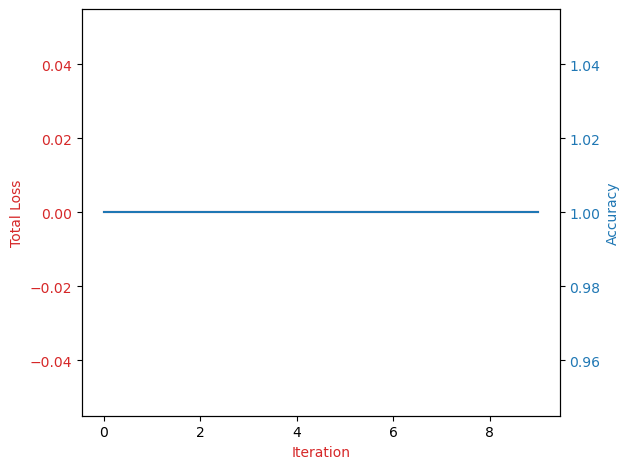

In [80]:
# Use the stored training loss and validation accuracy to plot learning curves
plot_stuff(loss_list, accuracy_list)

## Interpret the Learning Curves

Observe the plot of training loss and validation accuracy over the training iterations:

1. What trend do you observe in the training loss?

- It decreases steadily   

2. What trend do you observe in the validation accuracy?

- It improves consistently

# Model Testing

#### Define the class name and Load the model

## Load a Trained Model for Inference

In [99]:
# Define class labels used during training
class_names = ['not_stop', 'stop']  

# Load the same pretrained architecture used during training
# Should we use pretrained weights here? No → set False
model = models.resnet18(pretrained=False) 

# Replace the fully connected layer to match number of output classes
model.fc = torch.nn.Linear(model.fc.in_features, 1)  

# Load trained model weights
model.load_state_dict(torch.load("C:/Users/sujal/Downloads/model.pt", map_location=torch.device('cpu'))) 

# Set the model to evaluation mode
model.eval()  # Inference mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Preprocess an Image for Prediction

In [100]:
# Define the same image transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize image
    transforms.ToTensor(),               # Convert PIL image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize using ImageNet stats
                         [0.229, 0.224, 0.225])
])

## Load and convert the image

In [108]:
image_path = "C:/Users/sujal/Downloads/dataset/train/stop/0f1c3522-55f3-4f45-9242-c04f480d6df5.jpg"
image = Image.open(image_path).convert("RGB")  # Ensure 3 channels

# Apply transformations and add batch dimension
input_tensor = transform(image).unsqueeze(0)

#### We use `unsqueeze(0)` to add a batch dimension to the image tensor. PyTorch models expect input data in the shape `(batch_size, channels, height, width)`. Since a single image has the shape `(channels, height, width)`, we add an extra dimension at index 0 to represent a batch of size 1.

## Make a Prediction and Display the Result

The image was classified as: not_stop


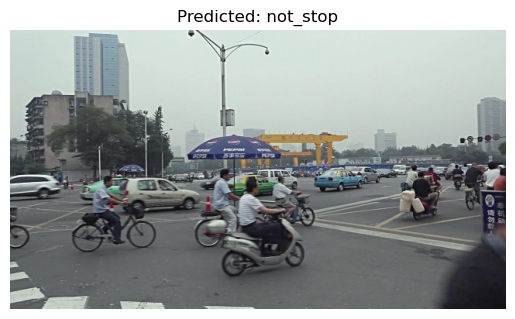

In [109]:
# Perform inference without tracking gradients
with torch.no_grad():  
    outputs = model(input_tensor)  # Forward pass
    predicted_class = torch.argmax(outputs, dim=1).item()  # Get predicted class index

# Display result
print(f"The image was classified as: {class_names[predicted_class]}")

# Visualize the image with the predicted label
plt.imshow(image)  # Original image (PIL format)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()